In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image


In [2]:
!pip install thop

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Number of classes: 10
Class Names: ['3_long_blade_rotor', '3_short_blade_rotor_1', '3_short_blade_rotor_2', 'Bird', 'Bird+mini-helicopter_1', 'Bird+mini-helicopter_2', 'RC plane_1', 'RC plane_2', 'drone_1', 'drone_2']


100%|██████████| 13.6M/13.6M [00:00<00:00, 149MB/s]



Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14   

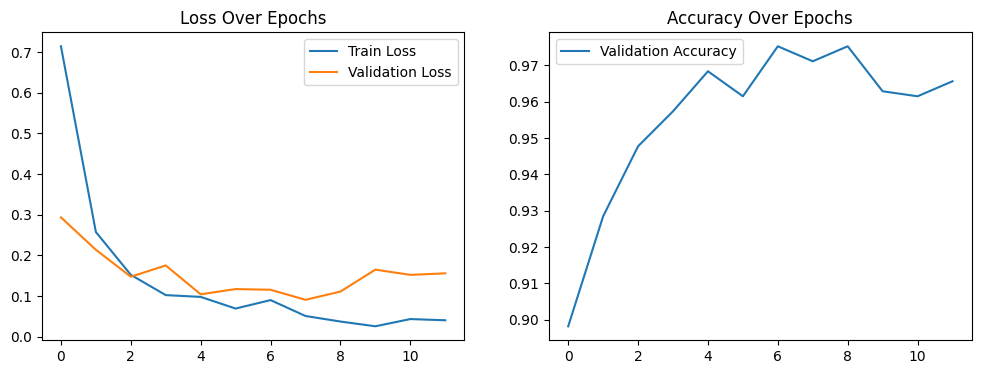

<ipython-input-3-e0ded088fb18>:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilenet_finetuned.pth"))



Evaluating on test set...

Classification Report:
                        precision    recall  f1-score   support

    3_long_blade_rotor       0.96      1.00      0.98       115
 3_short_blade_rotor_1       0.97      0.94      0.96        70
 3_short_blade_rotor_2       0.98      0.93      0.96        59
                  Bird       1.00      1.00      1.00       123
Bird+mini-helicopter_1       1.00      0.85      0.92        55
Bird+mini-helicopter_2       0.92      1.00      0.96        56
            RC plane_1       0.98      0.96      0.97        50
            RC plane_2       0.90      0.96      0.93        57
               drone_1       1.00      0.95      0.98        66
               drone_2       0.96      1.00      0.98        77

              accuracy                           0.97       728
             macro avg       0.97      0.96      0.96       728
          weighted avg       0.97      0.97      0.97       728



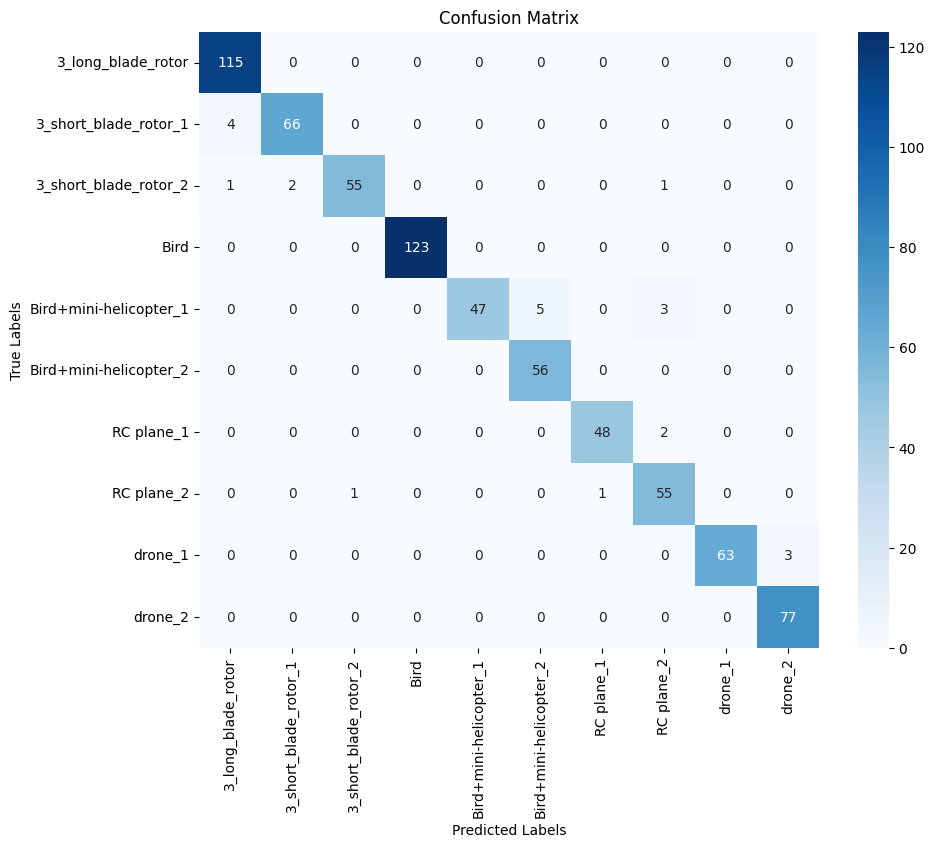


Multi-class ROC AUC Score: 0.9985


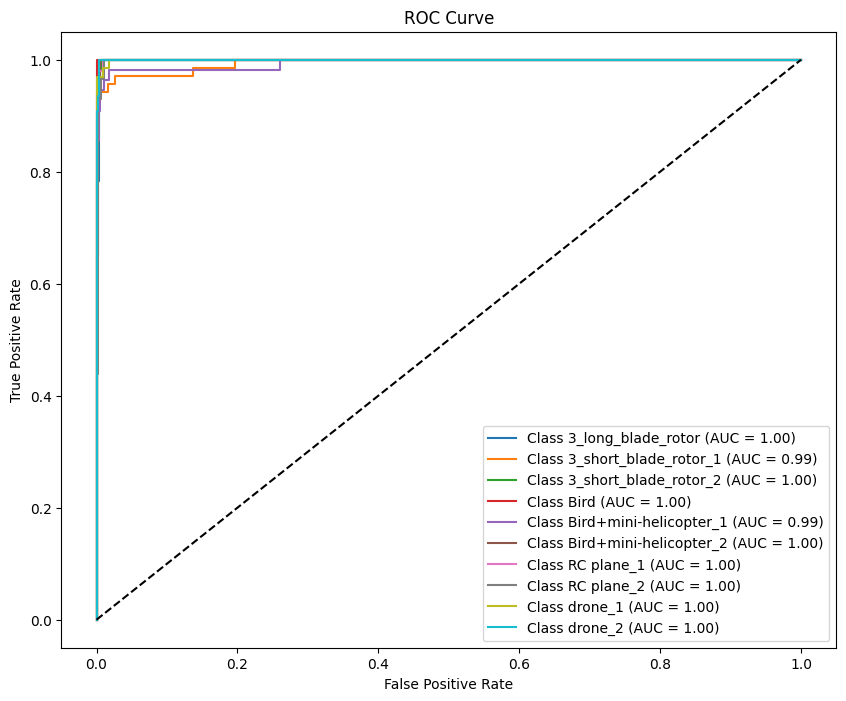

Total Number of Parameters: 2,236,682
Average Inference Time per Sample: 7.302 ms
FLOPs: 326,219,520.0 (326.22 M)
MACs: 2,236,682.0 (2.24 M)

✅ Accuracy for class '3_long_blade_rotor': 100.00%
✅ Accuracy for class '3_short_blade_rotor_1': 94.29%
✅ Accuracy for class '3_short_blade_rotor_2': 93.22%
✅ Accuracy for class 'Bird': 100.00%
✅ Accuracy for class 'Bird+mini-helicopter_1': 85.45%
✅ Accuracy for class 'Bird+mini-helicopter_2': 100.00%
✅ Accuracy for class 'RC plane_1': 96.00%
✅ Accuracy for class 'RC plane_2': 96.49%
✅ Accuracy for class 'drone_1': 95.45%
✅ Accuracy for class 'drone_2': 100.00%

✅ Test Set Accuracy: 0.968
📊 Model Size: 8.53 MB


In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchsummary import summary
from thop import profile  # For FLOPs and MACs calculation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Helper function for formatting large numbers
def format_units(num):
    """Format large numbers with units (K, M, G, etc.)"""
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return f"{num:.2f} {['', 'K', 'M', 'G', 'T', 'P'][magnitude]}"

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
batch_size = 16
img_size = 224  # MobileNet requires 224x224 images
num_epochs = 50  # Increased for better training
learning_rate = 1e-4
split_ratio = [0.7, 0.15, 0.15]  # 70% training, 15% validation, 15% test

# Dataset Directory
dataset_dir = "/kaggle/input/drone-usat/DIAT-uSAT_dataset"  # Change as needed

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Full Dataset
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Split into Train, Validation, and Test
train_size = int(split_ratio[0] * len(full_dataset))
val_size = int(split_ratio[1] * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Remaining for test
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of Classes
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes
print(f"Number of classes: {num_classes}")
print(f"Class Names: {class_names}")

# Load Pretrained MobileNet
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Model Summary
print("\nModel Summary:")
summary(model, (3, img_size, img_size))

# Training Loop
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
early_stop_counter = 0
early_stop_patience = 5

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print statistics
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    
    # Update learning rate scheduler
    scheduler.step(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "mobilenet_finetuned.pth")
        print(f"Model saved with validation accuracy: {val_accuracy:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    # Early stopping
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.savefig('training_history.png')
plt.show()

# Load the best model for evaluation
model.load_state_dict(torch.load("mobilenet_finetuned.pth"))
model.eval()

# Testing the Model
print("\nEvaluating on test set...")
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ROC Curve (for multi-class classification)
if num_classes > 2:
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_scores_array = np.array(y_scores)
    
    roc_auc = roc_auc_score(y_true_bin, y_scores_array, multi_class="ovr")
    print(f"\nMulti-class ROC AUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores_array[:, i])
        auc_score = roc_auc_score(y_true_bin[:, i], y_scores_array[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig("roc_curve.png")
    plt.show()

# Inference Time Calculation
sample_input = torch.randn(1, 3, img_size, img_size).to(device)
num_samples = 100
start_time = time.time()
for _ in range(num_samples):
    _ = model(sample_input)
inference_time = (time.time() - start_time) / num_samples

# Number of Parameters
num_params = sum(p.numel() for p in model.parameters())

# FLOPs & MACs Calculation
flops, macs = profile(model, inputs=(sample_input,), verbose=False)
# Convert inference time to milliseconds
inference_time_ms = inference_time * 1000

print(f"Total Number of Parameters: {num_params:,}")
print(f"Average Inference Time per Sample: {inference_time_ms:.3f} ms")
print(f"FLOPs: {flops:,} ({format_units(flops)})")
print(f"MACs: {macs:,} ({format_units(macs)})\n")

# Per-class accuracy
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"✅ Accuracy for class '{class_names[i]}': {acc:.2%}")

# Add these lines after the existing evaluation code (after collecting y_true, y_pred, y_scores)

# Calculate and display test accuracy with 3 decimal places
test_correct = sum([1 for i, j in zip(y_true, y_pred) if i == j])
test_total = len(y_true)
test_accuracy = test_correct / test_total
print(f"\n✅ Test Set Accuracy: {test_accuracy:.3f}")

# Calculate and display model size in MB
# Each parameter is typically stored as a 32-bit float (4 bytes)
model_size_bytes = num_params * 4
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"📊 Model Size: {model_size_mb:.2f} MB")